# Computational Social Science Project #2 

*Group number:* Group 4

*Group members:* Laura Pathak, Irem Inal, Val Sierra

*Semester:* Fall 2021


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send KQ a pull request on GitHub flagging the syntax that's tripping you up 

## 1. Introduction/Setup

#### a) Import relevant libraries
Add the other libraries you need for your code below and/or as you go. 

In [1]:
# import libraries you might need here 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. 

In [2]:
diabetes = pd.read_csv('Diabetes with Population Info by County 2017.csv', 
                       #CountyFips needs to be a string so leading 0 isn't dropped (this is only if you want to make choropleth map): 
                       dtype={"CountyFIPS": str})


In [3]:
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [4]:
pd.set_option('display.max_rows', 100) # tells pandas how many rows to display when printing so results don't get truncated

# look at the data types for each column in diabetes df 
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [5]:
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [6]:
# Now do the same as above, but for "Obesity_Number" :
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique())

# Irem: doing the same for Physical_Inactivity_Number : 
print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique())


['No Data']
['No Data']


The values contained in the two columns above making them objects (rather than integers) appear to be strings like "No Data" and "Suppressed." Let's drop those rows in the next section, and also recode Physical_Inactivity_Number to be an integer. 

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' to. 

In [7]:
# Diabetes
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"]  # note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!= "No Data"]
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 

# Physical Inactivity
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 


# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]
# change to numeric (specifically, integer or float?) from string (because originally included the "-" )
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

#Irem: looking at data types again
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                           int64
Obesity_Number                                                                                                                                            int64
Physical_Inactivity_Number                                                                                                                                int64
sex and age_total population

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [8]:
# select count variables to rc to percentages; make sure we leave out ratios and our population variable b/c these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 'sex and age_total population_sex ratio (males per 100 females)', 'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') # recode all selected columns to numeric

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [9]:
pd.set_option('display.max_columns', None)
# inspect recoded values
diabetes_summary = diabetes[rc_cols].describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,0.224208
Obesity_Number,3112.0,0.251666,0.088946,0.476788
Physical_Inactivity_Number,3112.0,0.200861,0.064949,0.392285
race_total population_one race,3112.0,0.976059,0.713126,1.000000
race_total population_two or more races,3112.0,0.023941,0.000000,0.286874
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000
race_total population_one race_black or african american,3112.0,0.090215,0.000000,0.874123
race_total population_one race_american indian and alaska native,3112.0,0.019398,0.000000,0.924799
race_total population_one race_american indian and alaska native_cherokee tribal grouping,3112.0,0.001791,0.000000,0.409669


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. 

In [10]:
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_one race_1',
 'sex and age_total population_18 years and over_1',
 'hispanic or latino and race_total population',
 'sex and age_total population_65 years and over_1',
 'race_total population_two or more races_1',
 'sex and age_total population']

In [11]:
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=['sex and age_total population_18 years and over_1',
 'race_total population_one race_1',
 'hispanic or latino and race_total population',
 'race_total population_two or more races_1',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population']) 

## 2. Exploratory Data Analysis

In [12]:
# let's look at the number of counties in each state
state_counts = diabetes.groupby('State', as_index=False)['County'].count()
state_counts

,State,County
0,Alabama,67
1,Alaska,29
2,Arizona,15
3,Arkansas,74
4,California,58
5,Colorado,64
6,Connecticut,8
7,Delaware,3
8,District of Columbia,1
9,Florida,67


In [13]:
# now, let's look at the counties with the *highest* levels of diabetes, physical inactivity, and obesity
top10_diabetes = diabetes[["County","State","CountyFIPS","Diabetes_Number"]].sort_values('Diabetes_Number', ascending=False).head(10)
top10_diabetes

,County,State,CountyFIPS,Diabetes_Number
5,Bullock County,Alabama,01011,0.224208
144,Jackson County,Arkansas,05067,0.222119
1941,Jones County,North Carolina,37103,0.213306
2183,Nowata County,Oklahoma,40105,0.210440
520,Telfair County,Georgia,13271,0.207757
18,Coosa County,Alabama,01037,0.207278
184,Woodruff County,Arkansas,05147,0.205105
516,Talbot County,Georgia,13263,0.202885
1126,Claiborne Parish,Louisiana,22027,0.201944
456,Hancock County,Georgia,13141,0.192150


In [14]:
top10_obesity = diabetes[["County","State","CountyFIPS","Obesity_Number"]].sort_values('Obesity_Number', ascending=False).head(10)
top10_obesity

,County,State,CountyFIPS,Obesity_Number
67,Aleutians East Borough,Alaska,02013,0.476788
2184,Okfuskee County,Oklahoma,40107,0.438217
1467,Sunflower County,Mississippi,28133,0.394316
407,Candler County,Georgia,13043,0.387457
2962,King And Queen County,Virginia,51097,0.387408
43,Macon County,Alabama,01087,0.386690
535,Warren County,Georgia,13301,0.378975
1926,Gates County,North Carolina,37073,0.377930
469,Johnson County,Georgia,13167,0.377903
1432,Jefferson County,Mississippi,28063,0.375715


In [15]:
top10_pa = diabetes[["County","State","CountyFIPS","Physical_Inactivity_Number"]].sort_values('Physical_Inactivity_Number',ascending=False).head(10)
top10_pa

,County,State,CountyFIPS,Physical_Inactivity_Number
169,Prairie County,Arkansas,05117,0.392285
1806,Harding County,New Mexico,35021,0.379085
333,Dixie County,Florida,12029,0.350916
160,Nevada County,Arkansas,05099,0.341706
3099,Mingo County,West Virginia,54059,0.338709
1470,Tippah County,Mississippi,28139,0.329650
480,Macon County,Georgia,13193,0.328783
112,Ashley County,Arkansas,05003,0.327945
1463,Sharkey County,Mississippi,28125,0.327200
17,Conecuh County,Alabama,01035,0.326275


In [16]:
# let's look at avg rates of diabates, obesity, and physical inactivity
state_means = diabetes.groupby('State', as_index=False)['Diabetes_Number','Obesity_Number','Physical_Inactivity_Number'].mean().rename(columns = {'Diabetes_Number': 'Avg Diabetes Rate','Obesity_Number': 'Avg Obesity Rate','Physical_Inactivity_Number':'Avg Physical Inactivity Rate'})
state_means

# sorted by avg diabetes rate, highest to lowest
state_means_sorted = state_means.sort_values('Avg Diabetes Rate',ascending=False)
state_means_sorted

<ipython-input-16-f52b44d9cecd>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  state_means = diabetes.groupby('State', as_index=False)['Diabetes_Number','Obesity_Number','Physical_Inactivity_Number'].mean().rename(columns = {'Diabetes_Number': 'Avg Diabetes Rate','Obesity_Number': 'Avg Obesity Rate','Physical_Inactivity_Number':'Avg Physical Inactivity Rate'})


,State,Avg Diabetes Rate,Avg Obesity Rate,Avg Physical Inactivity Rate
0,Alabama,0.127640,0.288034,0.239948
40,South Carolina,0.120790,0.286474,0.225997
48,West Virginia,0.119494,0.292064,0.220353
24,Mississippi,0.118071,0.299233,0.238497
3,Arkansas,0.112904,0.271585,0.250961
42,Tennessee,0.109382,0.266088,0.229609
10,Georgia,0.109146,0.259649,0.226371
33,North Carolina,0.106442,0.263668,0.207701
18,Louisiana,0.106157,0.284379,0.224360
9,Florida,0.102635,0.251093,0.239596


Text(0.5, 1.0, 'Top 10 Average Rates by State')

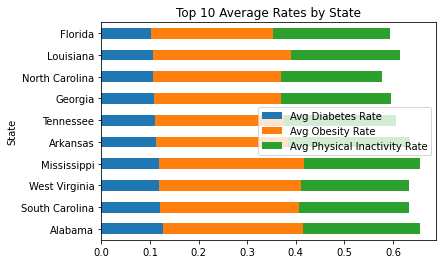

In [17]:
# let's make bar plot of the 10 states with highest average diabetes rates, along with their obesity and physical inactivity rates
state_means_sorted.head(10).plot.barh(x=0, stacked=True)
plt.title('Top 10 Average Rates by State')

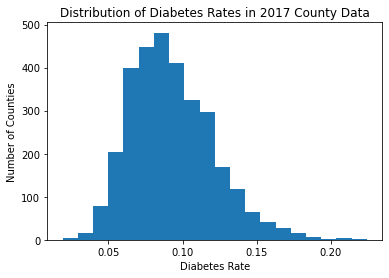

In [18]:
# let's look at the distributions of these variables
# histogram of Diabetes_Number (label)
plt.title('Distribution of Diabetes Rates in 2017 County Data')
plt.xlabel('Diabetes Rate')
plt.hist(diabetes['Diabetes_Number'], bins=20);
plt.ylabel('Number of Counties');

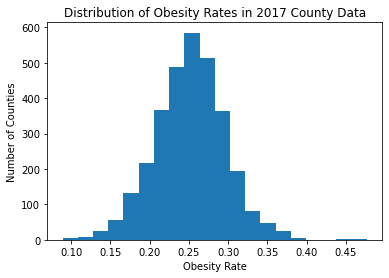

In [19]:
# histogram of Obesity_Number (feature)
plt.title('Distribution of Obesity Rates in 2017 County Data')
plt.xlabel('Obesity Rate')
plt.hist(diabetes['Obesity_Number'], bins=20);
plt.ylabel('Number of Counties');

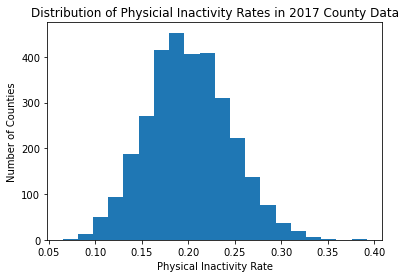

In [20]:
# histogram of Physical_Inactivity_Number (feature)
plt.title('Distribution of Physicial Inactivity Rates in 2017 County Data')
plt.xlabel('Physical Inactivity Rate')
plt.hist(diabetes['Physical_Inactivity_Number'], bins=20);
plt.ylabel('Number of Counties');

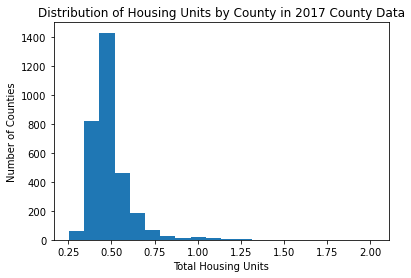

In [21]:
# histogram of total housing units (feature)
plt.title('Distribution of Housing Units by County in 2017 County Data')
plt.xlabel('Total Housing Units')
plt.hist(diabetes['total housing units'], bins=20);
plt.ylabel('Number of Counties');

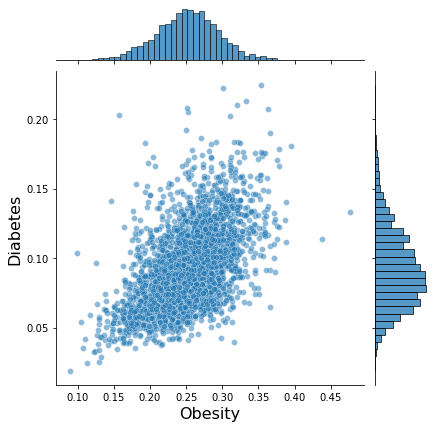

In [22]:
# let's look at the relationships between diabetes and various features
# scatterplot of diabetes and obesity
diabetes_obesity_plot = sns.jointplot(x = 'Obesity_Number', y = 'Diabetes_Number', data = diabetes, alpha = .5)
diabetes_obesity_plot.set_axis_labels('Obesity', 'Diabetes', fontsize=16)

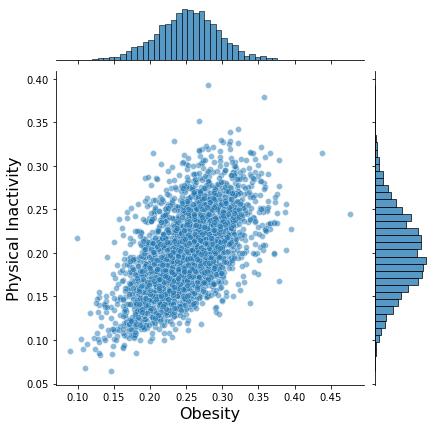

In [23]:
# scatterplot of obesity and physical inactivity
obesity_pa_plot = sns.jointplot(x = 'Obesity_Number', y = 'Physical_Inactivity_Number', data = diabetes, alpha = .5)
obesity_pa_plot.set_axis_labels('Obesity', 'Physical Inactivity', fontsize=16)

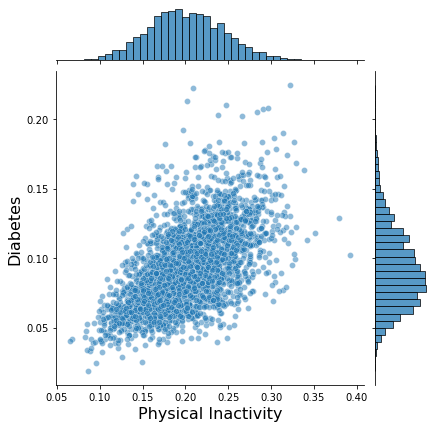

In [24]:
# scatterplot of diabetes and physical inactivity
diabetes_pa_plot = sns.jointplot(x = 'Physical_Inactivity_Number', y = 'Diabetes_Number', data = diabetes, alpha = .5)
diabetes_pa_plot.set_axis_labels('Physical Inactivity', 'Diabetes', fontsize=16)

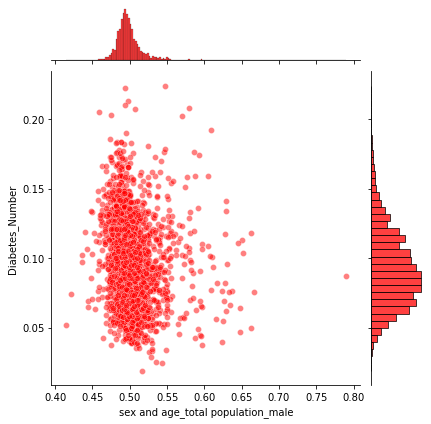

In [25]:
# scatterplots of diabetes and males
diabetes_male_plot = sns.jointplot(x = 'sex and age_total population_male', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='red')
diabetes_pa_plot.set_axis_labels('Proportion of Males', 'Diabetes', fontsize=16)

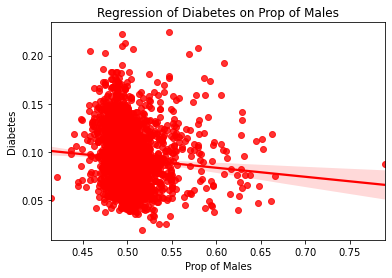

In [26]:
sns.regplot(x='sex and age_total population_male', y='Diabetes_Number', data=diabetes, color='red')
plt.title('Regression of Diabetes on Prop of Males')
plt.xlabel('Prop of Males')
plt.ylabel('Diabetes');

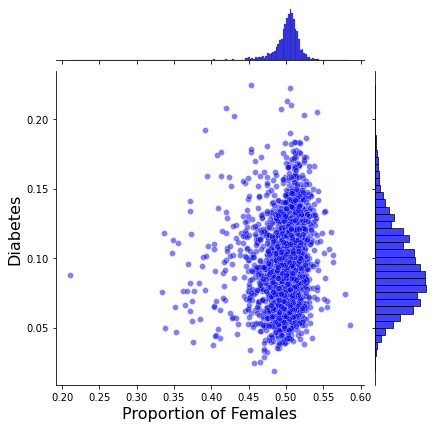

In [27]:
# scatterplots of diabetes and females
diabetes_female_plot = sns.jointplot(x = 'sex and age_total population_female', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='blue')
diabetes_female_plot.set_axis_labels('Proportion of Females', 'Diabetes', fontsize=16)

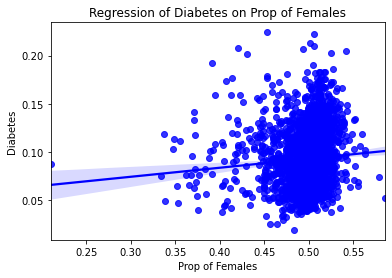

In [28]:
sns.regplot(x='sex and age_total population_female', y='Diabetes_Number', data=diabetes, color='blue')
plt.title('Regression of Diabetes on Prop of Females')
plt.xlabel('Prop of Females')
plt.ylabel('Diabetes');

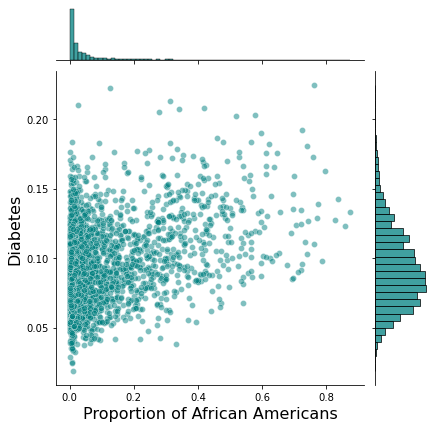

In [29]:
# scatterplots of diabetes and African Americans
diabetes_AA_plot = sns.jointplot(x = 'race_total population_one race_black or african american', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='teal')
diabetes_AA_plot.set_axis_labels('Proportion of African Americans', 'Diabetes', fontsize=16)

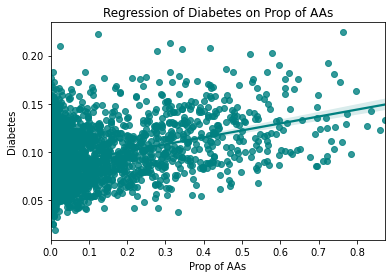

In [30]:
sns.regplot(x='race_total population_one race_black or african american', y='Diabetes_Number', data=diabetes, color='teal')
plt.title('Regression of Diabetes on Prop of AAs')
plt.xlabel('Prop of AAs')
plt.ylabel('Diabetes');

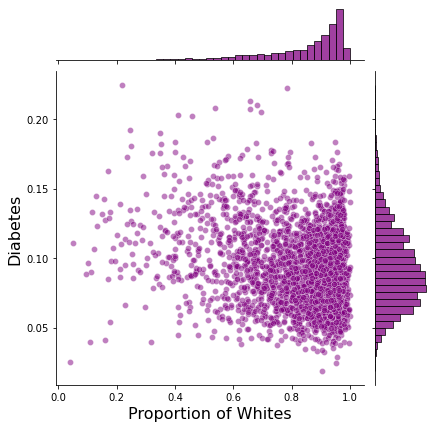

In [31]:
# scatterplots of diabetes and whites
diabetes_whites_plot = sns.jointplot(x = 'race_total population_one race_white', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='purple')
diabetes_whites_plot.set_axis_labels('Proportion of Whites', 'Diabetes', fontsize=16)

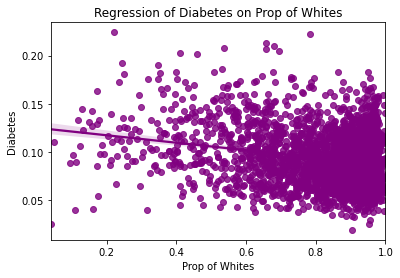

In [32]:
sns.regplot(x='race_total population_one race_white', y='Diabetes_Number', data=diabetes, color='purple')
plt.title('Regression of Diabetes on Prop of Whites')
plt.xlabel('Prop of Whites')
plt.ylabel('Diabetes');

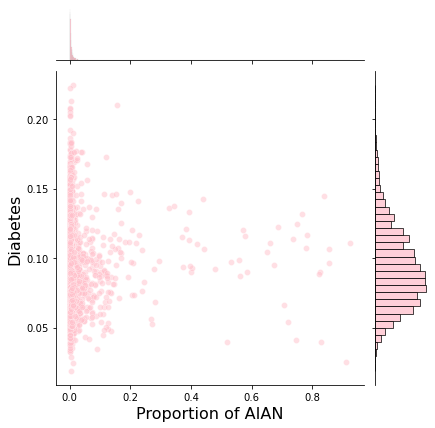

In [33]:
# scatterplots of diabetes and AIAN
diabetes_AIAN_plot = sns.jointplot(x = 'race_total population_one race_american indian and alaska native', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='pink')
diabetes_AIAN_plot.set_axis_labels('Proportion of AIAN', 'Diabetes', fontsize=16)

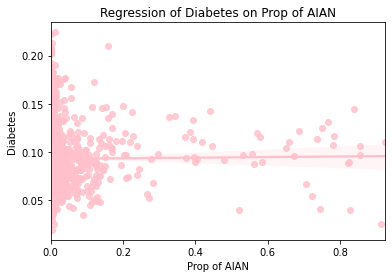

In [34]:
sns.regplot(x='race_total population_one race_american indian and alaska native', y='Diabetes_Number', data=diabetes, color='pink')
plt.title('Regression of Diabetes on Prop of AIAN')
plt.xlabel('Prop of AIAN')
plt.ylabel('Diabetes');

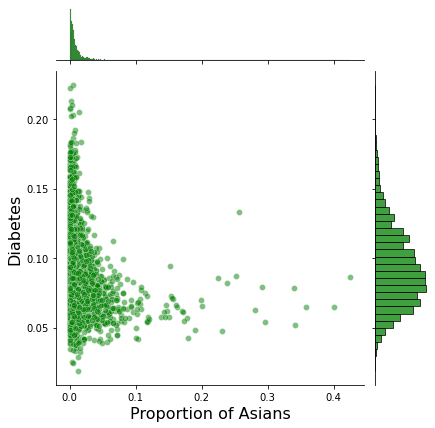

In [35]:
# scatterplots of diabetes and Asians
diabetes_Asians_plot = sns.jointplot(x = 'race_total population_one race_asian', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='green')
diabetes_Asians_plot.set_axis_labels('Proportion of Asians', 'Diabetes', fontsize=16)

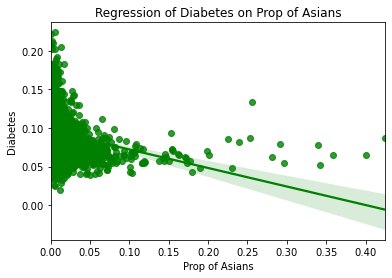

In [36]:
sns.regplot(x='race_total population_one race_asian', y='Diabetes_Number', data=diabetes, color='green')
plt.title('Regression of Diabetes on Prop of Asians')
plt.xlabel('Prop of Asians')
plt.ylabel('Diabetes');

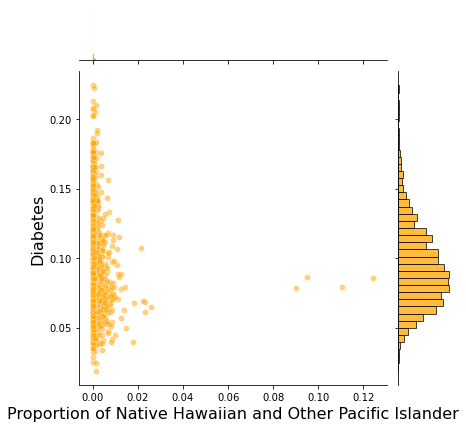

In [37]:
# scatterplots of diabetes and native hawaiian and other pacific islander
diabetes_API_plot = sns.jointplot(x = 'race_total population_one race_native hawaiian and other pacific islander', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='orange')
diabetes_API_plot.set_axis_labels('Proportion of Native Hawaiian and Other Pacific Islander', 'Diabetes', fontsize=16)

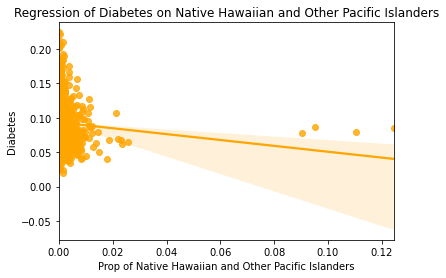

In [38]:
sns.regplot(x='race_total population_one race_native hawaiian and other pacific islander', y='Diabetes_Number', data=diabetes, color='orange')
plt.title('Regression of Diabetes on Native Hawaiian and Other Pacific Islanders')
plt.xlabel('Prop of Native Hawaiian and Other Pacific Islanders')
plt.ylabel('Diabetes');

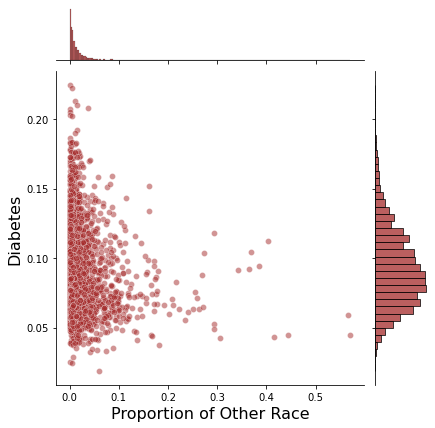

In [39]:
# scatterplots of diabetes and Other race
diabetes_Other_plot = sns.jointplot(x = 'race_total population_one race_some other race', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='brown')
diabetes_Other_plot.set_axis_labels('Proportion of Other Race', 'Diabetes', fontsize=16)

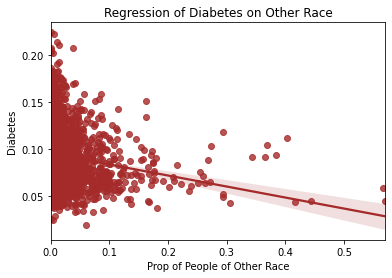

In [40]:
sns.regplot(x='race_total population_one race_some other race', y='Diabetes_Number', data=diabetes, color='brown')
plt.title('Regression of Diabetes on Other Race')
plt.xlabel('Prop of People of Other Race')
plt.ylabel('Diabetes');

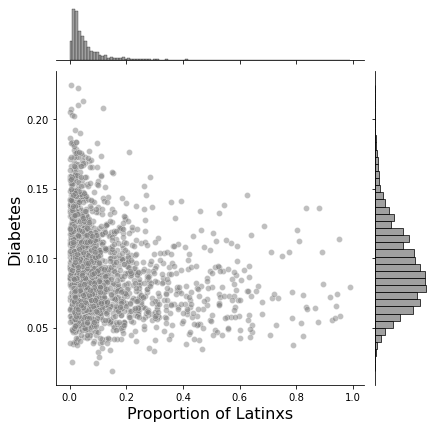

In [41]:
# scatterplots of diabetes and Latinxs
diabetes_Other_plot = sns.jointplot(x = 'hispanic or latino and race_total population_hispanic or latino (of any race)', y = 'Diabetes_Number', data = diabetes, alpha = .5, color='gray')
diabetes_Other_plot.set_axis_labels('Proportion of Latinxs', 'Diabetes', fontsize=16)

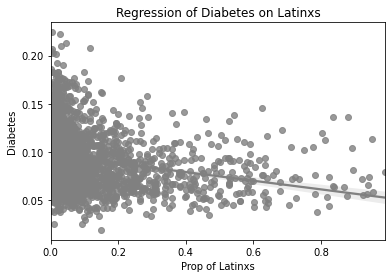

In [42]:
sns.regplot(x='hispanic or latino and race_total population_hispanic or latino (of any race)', y='Diabetes_Number', data=diabetes, color='gray')
plt.title('Regression of Diabetes on Latinxs')
plt.xlabel('Prop of Latinxs')
plt.ylabel('Diabetes');

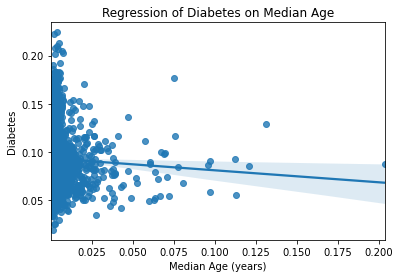

In [43]:
# scatterplot of diabetes and median age
sns.regplot(x='sex and age_total population_median age (years)', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on Median Age')
plt.xlabel('Median Age (years)')
plt.ylabel('Diabetes');

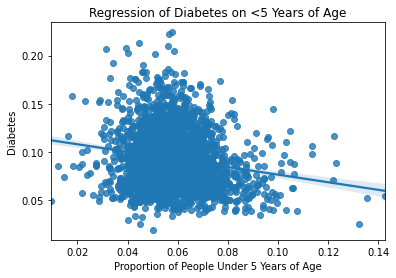

In [44]:
# the following are scatterplots of diabetes and different age groups
sns.regplot(x='sex and age_total population_under 5 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on <5 Years of Age')
plt.xlabel('Proportion of People Under 5 Years of Age')
plt.ylabel('Diabetes');

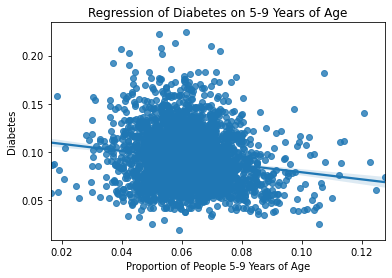

In [45]:
sns.regplot(x='sex and age_total population_5 to 9 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 5-9 Years of Age')
plt.xlabel('Proportion of People 5-9 Years of Age')
plt.ylabel('Diabetes');

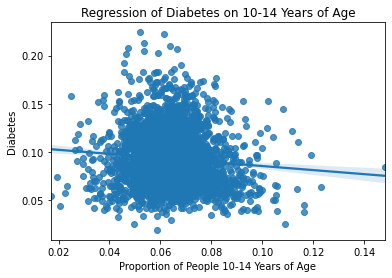

In [46]:
sns.regplot(x='sex and age_total population_10 to 14 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 10-14 Years of Age')
plt.xlabel('Proportion of People 10-14 Years of Age')
plt.ylabel('Diabetes');

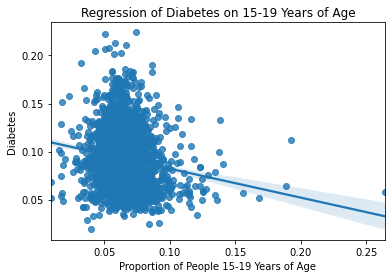

In [47]:
sns.regplot(x='sex and age_total population_15 to 19 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 15-19 Years of Age')
plt.xlabel('Proportion of People 15-19 Years of Age')
plt.ylabel('Diabetes');

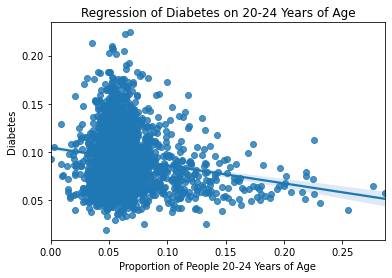

In [48]:
sns.regplot(x='sex and age_total population_20 to 24 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 20-24 Years of Age')
plt.xlabel('Proportion of People 20-24 Years of Age')
plt.ylabel('Diabetes');

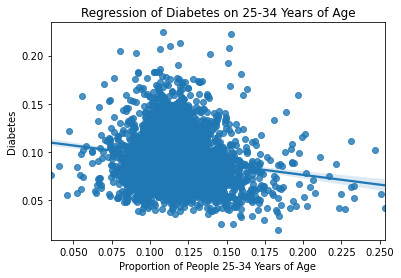

In [49]:
sns.regplot(x='sex and age_total population_25 to 34 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 25-34 Years of Age')
plt.xlabel('Proportion of People 25-34 Years of Age')
plt.ylabel('Diabetes');

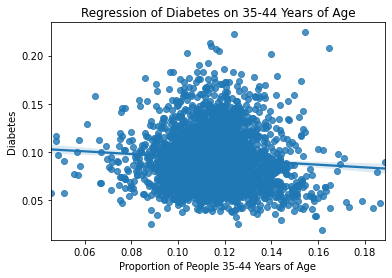

In [50]:
sns.regplot(x='sex and age_total population_35 to 44 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 35-44 Years of Age')
plt.xlabel('Proportion of People 35-44 Years of Age')
plt.ylabel('Diabetes');

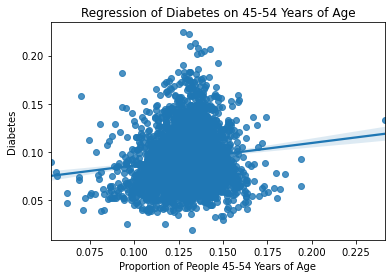

In [51]:
sns.regplot(x='sex and age_total population_45 to 54 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 45-54 Years of Age')
plt.xlabel('Proportion of People 45-54 Years of Age')
plt.ylabel('Diabetes');

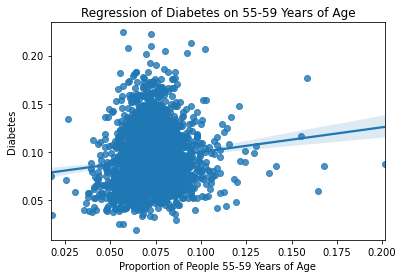

In [52]:
sns.regplot(x='sex and age_total population_55 to 59 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 55-59 Years of Age')
plt.xlabel('Proportion of People 55-59 Years of Age')
plt.ylabel('Diabetes');

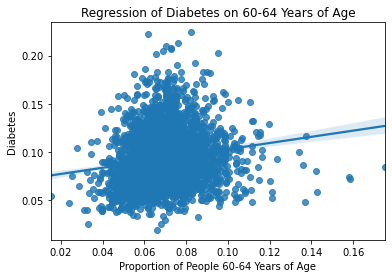

In [53]:
sns.regplot(x='sex and age_total population_60 to 64 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 60-64 Years of Age')
plt.xlabel('Proportion of People 60-64 Years of Age')
plt.ylabel('Diabetes');

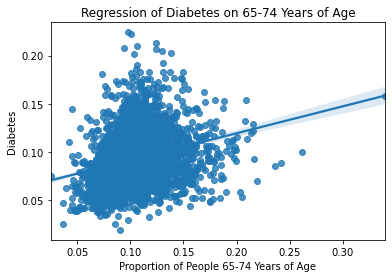

In [54]:
sns.regplot(x='sex and age_total population_65 to 74 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 65-74 Years of Age')
plt.xlabel('Proportion of People 65-74 Years of Age')
plt.ylabel('Diabetes');

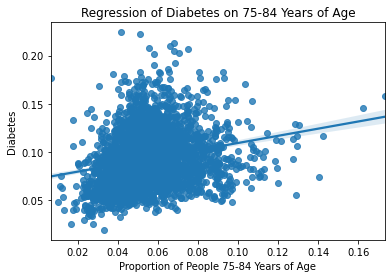

In [55]:
sns.regplot(x='sex and age_total population_75 to 84 years', y='Diabetes_Number', data=diabetes)
plt.title('Regression of Diabetes on 75-84 Years of Age')
plt.xlabel('Proportion of People 75-84 Years of Age')
plt.ylabel('Diabetes');

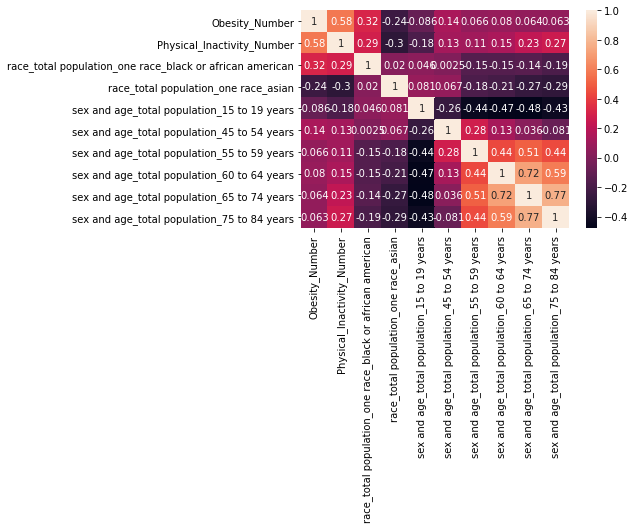

In [56]:
# From the Exploratory Data Analysis we can see that the following variables maybe be correlated with diabetes rates:
'Obesity_Number'
'Physical_Inactivity_Number'
'race_total population_one race_black or african american'
'sex and age_total population_45 to 54 years'
'sex and age_total population_55 to 59 years'
'sex and age_total population_60 to 64 years'
'sex and age_total population_65 to 74 years'
'sex and age_total population_75 to 84 years'

#Looking at the correlation matrix to avoid multicollinearity
df = pd.DataFrame(diabetes,columns=['Obesity_Number',
'Physical_Inactivity_Number',
'race_total population_one race_black or african american',
'race_total population_one race_asian',
'sex and age_total population_15 to 19 years',
'sex and age_total population_45 to 54 years',
'sex and age_total population_55 to 59 years',
'sex and age_total population_60 to 64 years',
'sex and age_total population_65 to 74 years',
'sex and age_total population_75 to 84 years'])
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'State' to be a categorical variable using `pd.get_dummies` and drop 'County' using `.drop()` because 'CountyFIPS' is already a unique identifier for the county. 

In [57]:
# create dummy features out of 'State' , which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['State'],  
                               drop_first = True) # only create 49 dummies by dropping first in category

# drop 'County' variable
diabetes_clean = diabetes_clean.drop(labels = ['County'],
                               axis =1) # which axis tells python we want to drop columns rather than index rows?


# look at first 10 rows of new data frame 
diabetes_clean.head(n=10) 

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2/3.3 Partition Data and Feature Selection

Now, we will partition our data to prepare it for the training process. We will use 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

In [58]:
from sklearn.model_selection import train_test_split

# Set y 
y = diabetes_clean['Diabetes_Number']

# X (everything except diabetes, our target)
X = diabetes_clean.drop(['Diabetes_Number'], 
                axis = 1)

Xdf = diabetes_clean.drop(['Diabetes_Number'], 
                axis = 1)

We should also preprocess our data. Using the `preprocessing` module from sklearn, let's scale our features so that they are mean-centered.

In [59]:
from sklearn import preprocessing

X = preprocessing.scale(X) #When we do this, X becomes a numpy array instead of df, which causes problems in selecting columns

We can also get rid of the 0 variance features using the `VarianceThreshold()` method from `feature_selection`. 

In [60]:
from sklearn import feature_selection

selector = feature_selection.VarianceThreshold(0)
X = selector.fit_transform(X) #Similarly, X is a numpy array at the end of this operation
X

array([[-1.9375102 , -0.16471873,  0.58515483, ..., -0.13288567,
        -0.15389675, -0.08242523],
       [-1.93737828, -0.4154411 , -0.19181486, ..., -0.13288567,
        -0.15389675, -0.08242523],
       [-1.93724635,  1.33084974,  0.21998678, ..., -0.13288567,
        -0.15389675, -0.08242523],
       ...,
       [ 1.6930249 , -0.28640652, -0.67657217, ..., -0.13288567,
        -0.15389675, 12.13220822],
       [ 1.69315682, -0.85439566,  0.20787775, ..., -0.13288567,
        -0.15389675, 12.13220822],
       [ 1.69328874,  0.72518908, -0.1364354 , ..., -0.13288567,
        -0.15389675, 12.13220822]])

And finally, let's split our data:

In [61]:
# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)


In [62]:
#Irem: checking shapes

print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_validate is", X_validate.shape)
print("Shape of y_validate is", y_validate.shape)
print("Shape of X_test is", X_test.shape)
print("Shape of y_test is", y_test.shape)

Shape of X train is (1866, 135)
Shape of y_train is (1866,)
Shape of X_validate is (623, 135)
Shape of y_validate is (623,)
Shape of X_test is (623, 135)
Shape of y_test is (623,)


## 4. Train Models

### 4.1 Model Description

OLS:

Ridge:

Lasso:

### 4.2 Train Models

In [63]:
# train your models in this section
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

### Val: OLS, Laura: Ridge, Irem: Lasso

In [64]:
#Create & Fit Model - OLS
lin_reg = LinearRegression(normalize=True)
lin_model = lin_reg.fit(X_train, y_train)
print(lin_model.coef_)
print(lin_model.intercept_)

[ 1.81141509e-01  6.98028379e-03  6.92264121e-03  8.35556577e-04
  1.40665744e-05 -1.22976799e+11 -1.26551353e+11 -3.09017929e+10
 -2.66138883e+10 -1.41170261e+10  9.93920848e-04 -1.62647342e-05
  4.23859715e-04  7.98833853e-04 -9.11423603e+10  2.29950373e+10
  2.34608614e+10  3.63522470e+10  1.15352720e+10  8.34909182e+09
  9.82775110e+09  1.85610817e+10  3.76360230e+10 -2.67183450e+10
 -4.70746071e+09 -6.78858942e+09 -1.23479259e+10 -7.18064099e+09
 -2.64556986e-03 -1.17598411e-02 -7.29429646e-03  1.74067937e-03
  5.60637656e-02 -1.78504450e-01 -8.06025455e-02 -1.66565658e-02
 -1.82013965e-02 -4.84920418e-02 -3.37701151e+09  7.43937926e+09
  8.21334924e+08  4.82597942e+08  2.23030320e+09  2.22616778e+10
 -2.51700598e+10 -1.79573648e+10 -9.36843319e+09 -3.43977679e+09
 -4.82105972e+08 -2.87371851e+08  2.87275430e+10 -1.60046743e+09
 -3.06292503e+10 -4.09312502e-04 -3.34622571e+10  2.27923766e+10
  2.04167496e+10  4.30642260e+11  4.30642260e+11 -2.13742351e-02
  2.19099268e+10  2.19172

In [65]:
#Create & Fit Model - Ridge
ridge_reg = Ridge()
ridge_model = ridge_reg.fit(X_train, y_train)
print(ridge_model.coef_)
print(ridge_model.intercept_)

[-3.91496358e-03  7.00527799e-03  7.00600843e-03  3.15599853e-04
 -9.12810288e-05 -1.19251515e-03  1.19251515e-03 -1.08157100e-02
  1.12623532e-02  3.34578884e-03  1.04243303e-03 -2.28631853e-05
  4.75472923e-04  6.99823126e-04  3.61454078e-03  1.91201860e-03
  3.13251232e-03  3.88244489e-03  1.77952497e-04  4.12897270e-04
  1.07243584e-03  1.95226016e-03 -4.24918512e-05 -6.86171192e-05
  5.79232186e-04 -2.63114011e-04 -5.98608195e-05 -4.94953228e-03
 -1.43580772e-03 -2.70993573e-03 -1.61290587e-03  3.38278250e-04
 -2.92063784e-04  7.05731609e-04 -1.36867522e-02 -1.41558154e-02
 -6.95518997e-03  2.32930699e-03  1.70921427e-03  2.06771261e-03
 -3.78601090e-04 -4.10402663e-04 -2.80975675e-04 -1.70921427e-03
  5.13142258e-03 -1.30501344e-02  8.13023902e-03 -1.87867126e-03
  1.74407355e-03  3.97440674e-04  2.37573064e-03 -7.17235804e-05
  2.39365569e-03 -3.20167827e-04  1.53846845e-04 -4.01672115e-04
  7.00558370e-04  4.87505370e-03 -4.87505370e-03 -1.42885269e-02
 -1.34306744e-03 -2.36169

In [66]:
#Create & Fit Model - Lasso
lasso_reg = Lasso(alpha=0.01)
lasso_model = lasso_reg.fit(X_train, y_train)
print(lasso_model.coef_)
print(lasso_model.intercept_)

[ 0.          0.00188678  0.00602429 -0.         -0.          0.
 -0.         -0.          0.          0.          0.         -0.
  0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.         -0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.
  0.          0.          0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.          0.          0.          0.
  0.          0.          0.          0.         -0.          0.
  0.         -0.          0.          0.         -0.         -0.
 -0.          0.         

In [67]:
#Visualize Coefficients & Features - OLS

lin_reg_data = pd.DataFrame([lin_model.coef_, Xdf.columns]).T #Irem: columns have to be taken from the data frame X, not array X 
lin_reg_data.columns = ['Coefficient', 'Feature']

#Converting features into numeric and string for the barplot
lin_reg_data = lin_reg_data.convert_dtypes()
lin_reg_data.dtypes

#Visualize Coefficients & Features - Ridge
ridge_reg_data = pd.DataFrame([ridge_model.coef_, Xdf.columns]).T
ridge_reg_data.columns = ['Coefficient', 'Feature']

ridge_reg_data = ridge_reg_data.convert_dtypes()
ridge_reg_data.dtypes

#Visualize Coefficients & Features - Lasso
lasso_reg_data = pd.DataFrame([lasso_model.coef_, Xdf.columns]).T
lasso_reg_data.columns = ['Coefficient', 'Feature']

lasso_reg_data = lasso_reg_data.convert_dtypes()
lasso_reg_data.dtypes

Coefficient    Float64
Feature         string
dtype: object

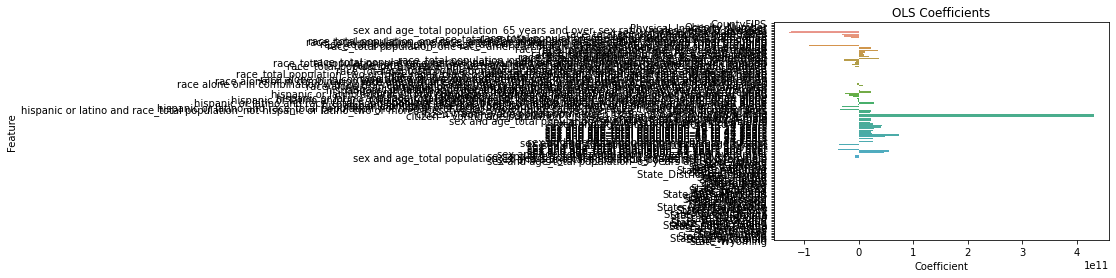

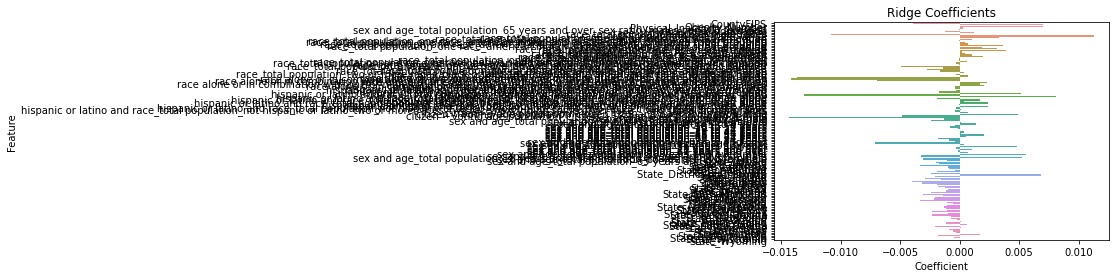

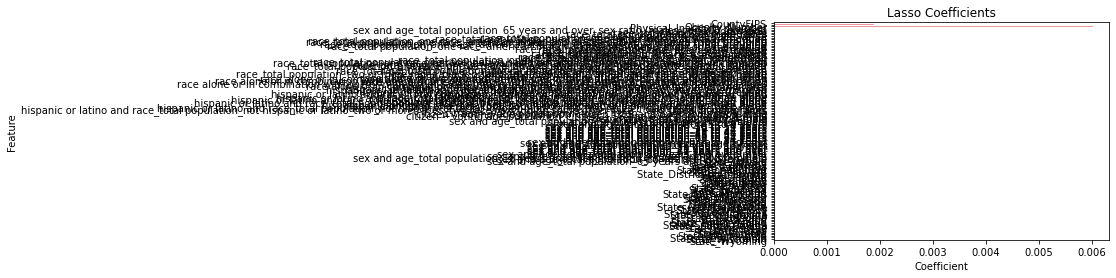

In [68]:
#Visualize Coefficients & Features - OLS
sns.barplot(x='Coefficient', y='Feature', data=lin_reg_data).set_title("OLS Coefficients")
plt.show()

#Visualize Coefficients & Features - Ridge
sns.barplot(x="Coefficient", y="Feature", data=ridge_reg_data).set_title("Ridge Coefficients")
plt.show()

#Visualize Coefficients & Features - Lasso
sns.barplot(x="Coefficient", y="Feature", data=lasso_reg_data).set_title("Lasso Coefficients")
plt.show()

### Comments for part 4.2:





## 5. Validate and Refine Models

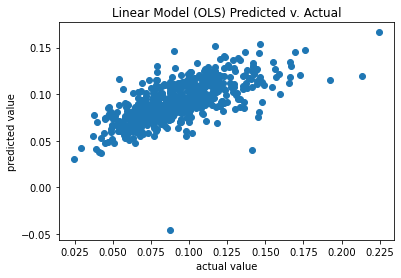

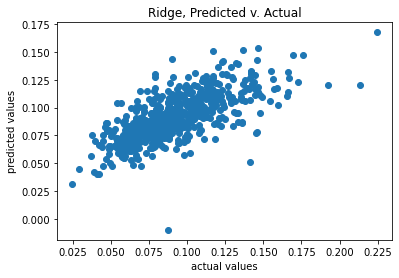

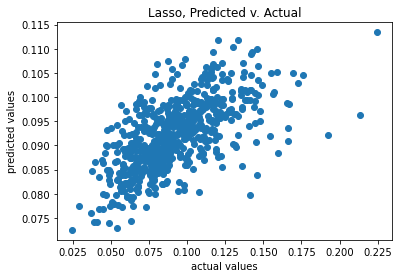

In [69]:
# use X_validation and y_validation data sets to evaluate and refine your models

# Prediction & Residuals Scatter Plot - OLS
lin_pred = lin_model.predict(X_validate)

plt.scatter(y_validate, lin_pred)
plt.title('Linear Model (OLS) Predicted v. Actual')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

# Prediction & Residuals Scatter Plot - Ridge
ridge_pred = ridge_model.predict(X_validate)

plt.scatter(y_validate, ridge_pred)
plt.title('Ridge, Predicted v. Actual')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

# Prediction & Residuals Scatter Plot - Lasso
lasso_pred = lasso_model.predict(X_validate)

plt.scatter(y_validate, lasso_pred)
plt.title('Lasso, Predicted v. Actual')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [70]:
# Calculate Root Mean Square Error - OLS
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))
print(rmse(lin_pred, y_validate))

# Calculate Root Mean Square Error - Ridge
print(rmse(ridge_pred, y_validate))

# Calculate Root Mean Square Error - Lasso
print(rmse(lasso_pred, y_validate))

0.020342191165860012
0.019813579023018554
0.023920459995272054


In [71]:
# Hyperparameter Tuning

# OLS
param_grid = {'fit_intercept': ['True', 'False'],
              'normalize': ['True', 'False']}

lin_grid_reg = GridSearchCV(lin_reg, param_grid, cv=3)
lin_grid_reg.fit(X_train, y_train)

best_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)

print(lin_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2, OLS:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2, OLS:', lin_grid_reg.score(X_validate, y_validate))
print('Validation RMSE, OLS', rmse(best_lin_pred, y_validate))

# RIDGE
param_grid = {'alpha': np.arange(.01, 1, .01),
              'normalize': ['True', 'False'],
              'fit_intercept': ['True', 'False'],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=3)
ridge_grid_reg.fit(X_train, y_train)

best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)

print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2, Ridge:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2, Ridge:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE, Ridge', rmse(best_ridge_pred, y_validate))

# LASSO
param_grid = {'alpha': np.arange(.01, 1, .01),
              'normalize': ['True', 'False'],
              'fit_intercept': ['True', 'False'],
              'selection': ['cyclic', 'random']}

lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=3)
lasso_grid_reg.fit(X_train, y_train)

best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)

print(lasso_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2, Lasso:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2, Lasso:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE, Lasso', rmse(best_lasso_pred, y_validate))

{'fit_intercept': 'True', 'normalize': 'True'}
Best CV R^2, OLS: -4.2406304181355946e+57
Validation R^2, OLS: 0.46300496011207337
Validation RMSE, OLS 0.020342191165860012
{'alpha': 0.04, 'fit_intercept': 'True', 'normalize': 'True', 'solver': 'svd'}
Best CV R^2, Ridge: -1.8798966445774878
Validation R^2, Ridge: 0.5281415956751572
Validation RMSE, Ridge 0.0190685838787769
{'alpha': 0.01, 'fit_intercept': 'True', 'normalize': 'True', 'selection': 'cyclic'}
Best CV R^2, Lasso: -0.0014479879063390804
Validation R^2, Lasso: -0.0004956340499586709
Validation RMSE, Lasso 0.027766439466639033


In [72]:
# Choosing the best model with best hyperparameter values

# OLS
best_pred = lin_grid_reg.best_estimator_.predict(X_test)
print('Best CV R^2, OLS:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2, OLS:', lin_grid_reg.score(X_test, y_test))
print('Test RMSE, OLS', rmse(best_pred, y_test))

# RIDGE
best_pred = ridge_grid_reg.best_estimator_.predict(X_test)
print('Best CV R^2, Ridge:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2, Ridge:', ridge_grid_reg.score(X_test, y_test))
print('Test RMSE, Ridge', rmse(best_pred, y_test))

# LASSO
best_pred = lasso_grid_reg.best_estimator_.predict(X_test)
print('Best CV R^2, Lasso:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2, Lasso:', lasso_grid_reg.score(X_test, y_test))
print('Test RMSE, Lasso', rmse(best_pred, y_test))

Best CV R^2, OLS: -4.2406304181355946e+57
Test R^2, OLS: 0.48583238395317285
Test RMSE, OLS 0.01996201124645377
Best CV R^2, Ridge: -1.8798966445774878
Test R^2, Ridge: 0.495923152522315
Test RMSE, Ridge 0.019765158949441617
Best CV R^2, Lasso: -0.0014479879063390804
Test R^2, Lasso: -0.0010328237308134813
Test RMSE, Lasso 0.0278532639707872


## 6. Discussion Questions

In [73]:
# insert responses for discussion Qs here